In [1]:
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

env: WANDB_SILENT=true


In [2]:
import torch
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure, LearnedPerceptualImagePatchSimilarity
import utils
from models import UNetMod, UNetModECA, FC_ECA, FC_ECA1
from denoisers.dip import DIP, DDIP, SGDIP, PatchDIP, losses, schedules

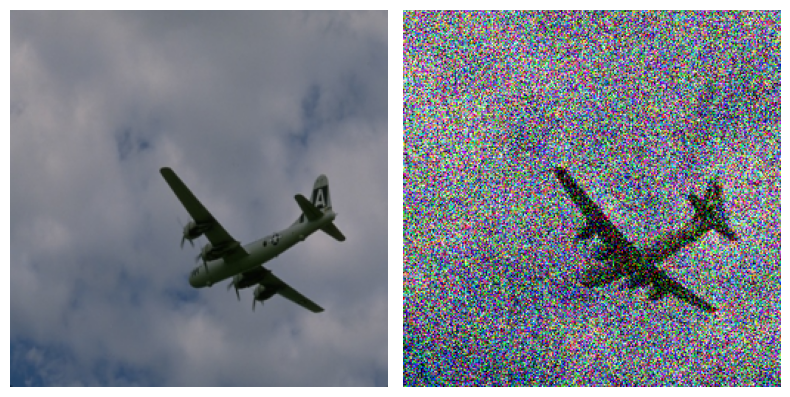

tensor(9.9910)


In [3]:
# clean = utils.load_celeba(30)
clean = utils.load_images('./data/CBSD68/')[:2]
# clean = utils.load_images('./data/Set14/')
# clean = utils.load_image("./data/set5/butterfly.png")
noisy = torch.stack([utils.get_noisy_image(img, 10) for img in clean])

utils.plot_row([clean[0], noisy[0]])

psnr = PeakSignalNoiseRatio(data_range=2)
print(psnr(noisy, clean))

In [4]:
# networks
net = UNetMod(hidden_ch=8, n_layers=4)
net1 = UNetModECA(hidden_ch=8, n_layers=4)
net2 = UNetModECA(hidden_ch=64, n_layers=2)
net3 = FC_ECA(3*24*24, freeze=False)
net4 = FC_ECA1(3*24*24, freeze=False)

# schedules
linear = schedules.Linear(1, 10)
cos = schedules.Cos(0.1)

# losses
mse = losses.MSE()
nmse = losses.NMSE()

mse_ae = losses.Composed(losses.MSE(), losses.AE())
nmse_ae = losses.Composed(losses.NMSE(), losses.AE())

mse_tv = losses.Composed(losses.MSE(), losses.TV(), alpha=0.1)
nmse_tv = losses.Composed(losses.NMSE(), losses.TV(), alpha=0.1)

# variants
dip = DIP(net, losses.MSE())
dip_es = DIP(net, losses.MSE(), early_stopping=True)
dip_neighbor = DIP(net, losses.NMSE())
dip_neighbor_es = DIP(net, losses.NMSE(), early_stopping=True)
dip_tv = DIP(net, mse_tv)
dip_tv_es = DIP(net, mse_tv, early_stopping=True)

sgdip = SGDIP(net, mse_ae)
sgdip_es = SGDIP(net, mse_ae, early_stopping=True)
sgdip_neighbor = SGDIP(net, nmse_ae)
sgdip_neighbor_es = SGDIP(net, nmse_ae, early_stopping=True)

ddip = DDIP(net, losses.MSE(), cos)
ddip_neighbor = DDIP(net, losses.NMSE(), cos)

patch_dip = PatchDIP(net2, losses.MSE(), epochs=20, threshold=0.2)
patch_dip2 = PatchDIP(net4, losses.MSE(), epochs=20, threshold=0.2)

d:\Code\ML\zero-shot-das-denoising\.venv\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
denoisers = [
    # sgdip_neighbor_es,
    # sgdip_es,
    # SGDIP(net, mse_ae.with_alpha(linear)),
    # SGDIP(net, nmse_ae.with_alpha(linear)),
    # dip_es,
    # dip_tv,
    # ddip,
    # ddip_neighbor,
    patch_dip,
    # patch_dip2,
    # DIP(net1, mse, early_stopping=True),
    # SGDIP(net1, mse_ae, early_stopping=True),
    # SGDIP(net1, mse_ae.with_alpha(linear)),
    # SGDIP(net1, nmse_ae.with_alpha(linear)),
    # DDIP(net1, mse, cos),
    # DIP(net, mse, early_stopping=True),
    # SGDIP(net, mse_ae, early_stopping=True),
    # SGDIP(net, mse_ae.with_alpha(linear)),
    # SGDIP(net, nmse_ae.with_alpha(linear)),
    # DDIP(net, mse, cos),
]

metrics = {
    "psnr": PeakSignalNoiseRatio(data_range=2),
    "ssim": StructuralSimilarityIndexMeasure(data_range=2),
}

results = {}
for i, denoiser in enumerate(denoisers):
    outputs = []
    for j, (y, x) in enumerate(zip(noisy, clean)):
        options = {
            "mode": "local",
            "config": {
                "project": "zero-shot-das-denoising",
                "entity": "jmaen-team",
                "group": "eca 3",
                "dataset": "cbsd68-10",
                "denoiser_id": i,
                "data_id": j,
            },
            "metrics": metrics,
            "log_output": False,
        }
        output = denoiser.denoise(y.unsqueeze(0), x.unsqueeze(0), options)
        output = output.detach().clone().cpu()
        outputs.append(output)

    results[f"{i} - {denoiser.name()}"] = torch.cat(outputs)

Running: 0 - PatchDIP (epochs=20) - MSE - UNetMod ECA 


100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


Summary: {'runtime': '00:00:35', 'psnr': 9.87453556060791, 'ssim': 0.006150966044515371}

Running: 1 - PatchDIP (epochs=20) - MSE - UNetMod ECA 


100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


Summary: {'runtime': '00:00:33', 'psnr': 9.689827919006348, 'ssim': 0.05357162654399872}

Running: 0 - PatchDIP (epochs=20) - MSE - FC SE 2024 


  0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x768 and 1728x128)

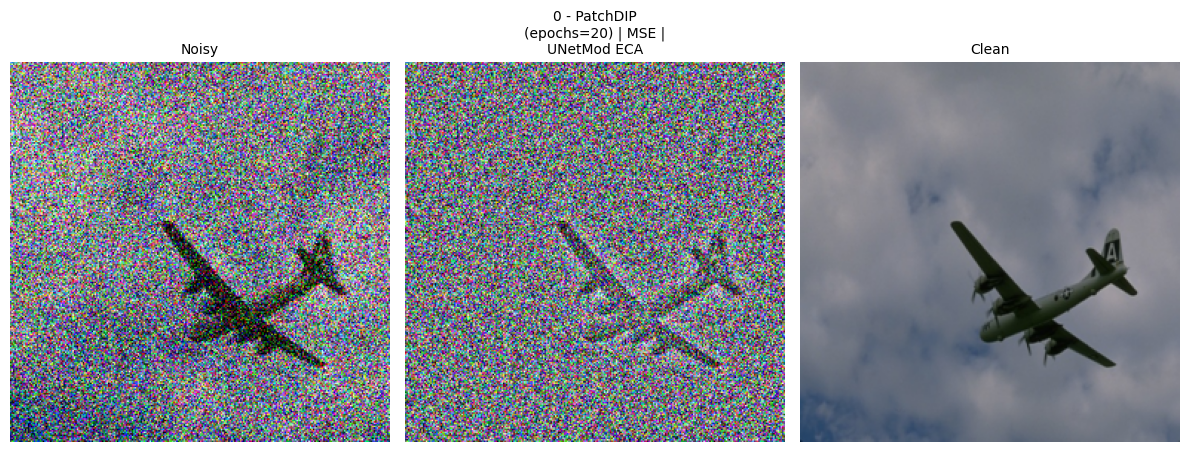

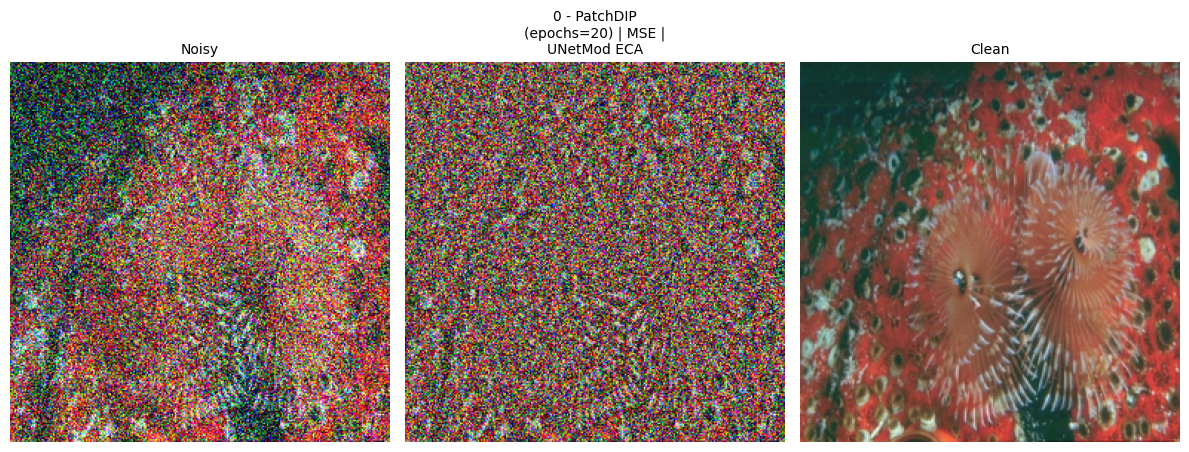

In [6]:
for result in zip(noisy, *results.values(), clean):
    utils.plot_row(result, ["Noisy", *list(results.keys()), "Clean"])

In [7]:
metrics = {
    "PSNR": PeakSignalNoiseRatio(data_range=2, reduction=None, dim=[1, 2, 3]),
    "SSIM": StructuralSimilarityIndexMeasure(data_range=2, reduction=None),
    # "LPIPS": LearnedPerceptualImagePatchSimilarity(),
}

for key, metric in metrics.items():
	print(key)
	print("----------")
	print(f"Noisy:".ljust(60), f"{metric(noisy, clean).mean()}")
	for name, xs in results.items():
		s = metric(xs, clean)
		print(f"{name}:".ljust(60), f"{s.mean()} ({s.var()})\t{s.tolist()}")
	print("\n")

PSNR
----------
Noisy:                                                       9.991042137145996
0 - PatchDIP (epochs=20) | MSE | UNetMod ECA :               9.782181739807129 (0.01705845631659031)	[9.87453556060791, 9.689827919006348]


SSIM
----------
Noisy:                                                       0.04460877180099487
0 - PatchDIP (epochs=20) | MSE | UNetMod ECA :               0.029861299321055412 (0.001124359667301178)	[0.006150966975837946, 0.05357163026928902]


